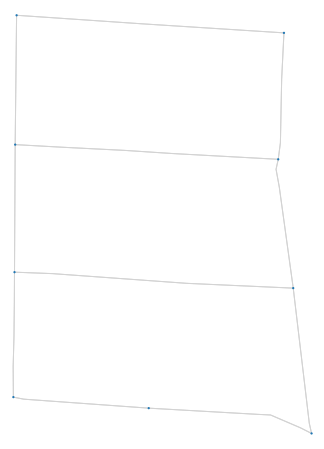

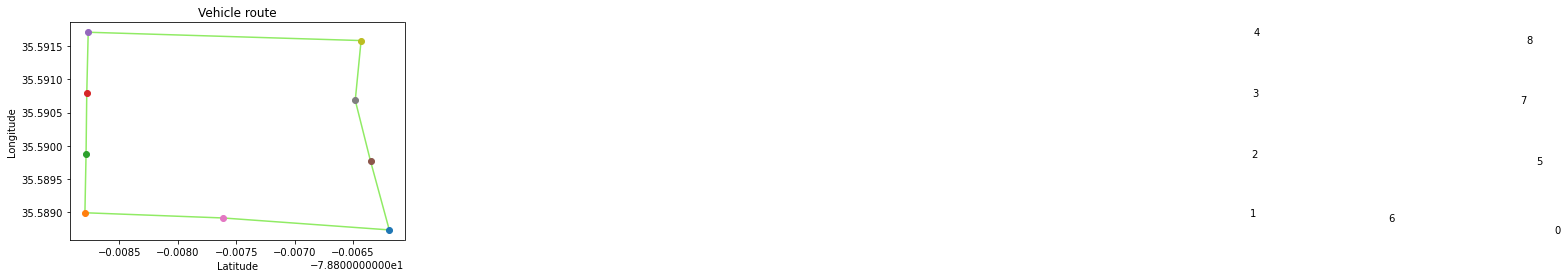

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]
2
1
6
0
5
7
8
4
3


In [38]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

#Creating a bounding box
north, south, east, west = 35.588654,35.591812,-78.808848,-78.806101
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost


for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != 2 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != 2 and j!= 2) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=2:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(9):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
order1 = [1,6,0,5,2]
order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
df4 = pd.DataFrame()
for i in order2:
    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
for i in df4.index:
    long3.append(df4.loc[i]["Longitude"])
    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [12]:
routes[0][3][0]

0

In [13]:
routes

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]

In [35]:
a=[]
for i in range(9):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 

2
1
6
0
5
7
8
4
3


In [39]:
bb1 = [35.588654,35.591812,-78.808848,-78.806101]

In [40]:
type(bb1)

list

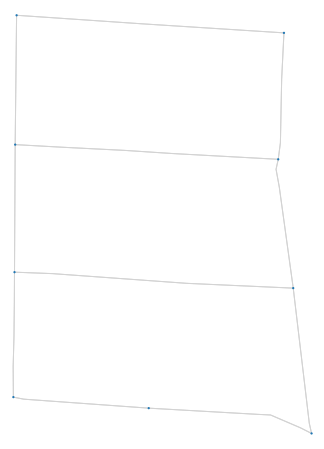

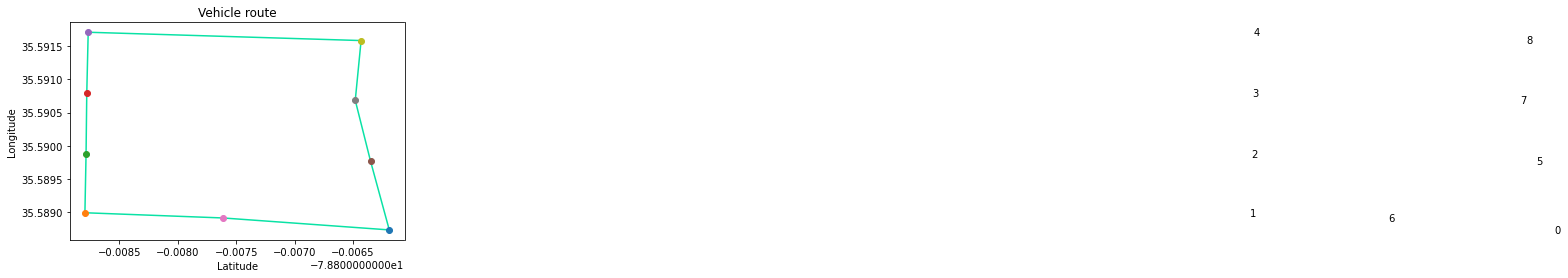

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]
2
1
6
0
5
7
8
4
3


In [42]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

#Creating a bounding box
north, south, east, west = bb1[0],bb1[1],bb1[2],bb1[3]
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(9):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
order1 = [1,6,0,5,2]
order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
df4 = pd.DataFrame()
for i in order2:
    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
for i in df4.index:
    long3.append(df4.loc[i]["Longitude"])
    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [43]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [44]:
bb1

[35.588654, 35.591812, -78.808848, -78.806101]

In [47]:
depot1 = 2

In [45]:
bb2 = [35.581702,35.584546,-78.800222,-78.797915]

In [46]:
depot2 = 8

In [64]:
data.index.stop-1

13

In [84]:
bb = []
bb.append(bb1)
bb.append(bb2)

In [94]:
for i in range(2):
    print(bb[i][0])

35.588654
35.581702


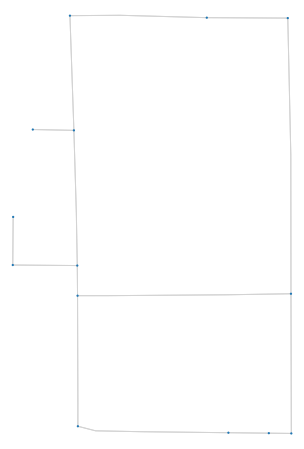

       0      1      2      3      4      5      6      7      8      9   \
0     0.0  135.3  397.7  101.7  187.2  259.8  217.7   82.6  346.4  213.3   
1   135.3    0.0  262.8  237.0  322.6  395.1   88.4  218.0  314.1  348.6   
2   397.7  262.8    0.0  296.0  210.4  137.9  174.4  315.0   51.3  236.5   
3   101.7  237.0  296.0    0.0   85.6  158.1  154.1   19.0  244.7  111.6   
4   187.2  322.6  210.4   85.6    0.0   72.6  239.6  104.6  159.2   26.1   
5   259.8  395.1  137.9  158.1   72.6    0.0  312.2  177.1   86.6   98.6   
6   217.7   88.4  174.4  154.1  239.6  312.2    0.0  135.1  225.7  265.7   
7    82.6  218.0  309.5   19.0  104.6  177.1  135.1    0.0  263.7  130.6   
8   346.4  314.1   51.3  244.7  159.2   86.6  225.7  263.7    0.0  185.2   
9   333.6  469.0  356.9  232.0  146.4  219.0  386.1  251.0  305.6    0.0   
10  142.5  277.8  336.8   40.8  126.4  198.9  194.9   59.8  285.5  152.4   
11  172.9  308.3  367.3   71.3  156.8  229.4  225.4   90.3  316.0  182.9   
12  121.1   

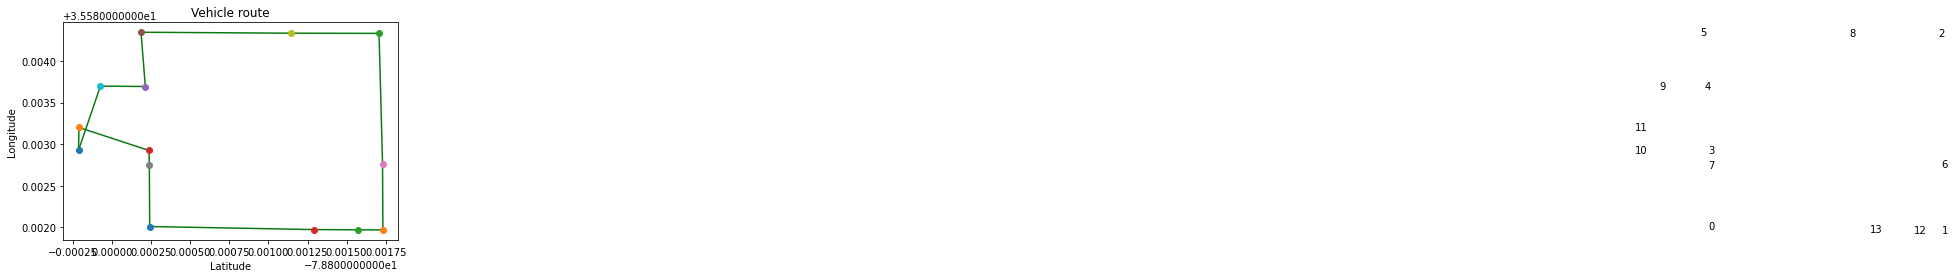

[[(2, 8), (8, 5), (5, 4), (4, 9), (9, 10), (10, 11), (11, 3), (3, 7), (7, 0), (0, 13), (13, 12), (12, 1), (1, 6), (6, 2)]]
2
8
5
4
9
10
11
3
7
0
13
12
1
6


In [69]:
for i in range(2):
    
    #Creating a bounding box
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
    Nodes = []
    for i in G.nodes:
        Nodes.append(i)

    data = pd.DataFrame(Nodes)
    data.rename(columns = {0:'Nodes'}, inplace = True)

    lat1 = []
    long1 = []
    for i in Nodes:
        lat1.append(G.nodes[i].get('y'))
        long1.append(G.nodes[i].get('x'))
    data['Latitude'] = lat1
    data['Longitude'] = long1
    df1 = data


    df1 = df1.drop(['Nodes'],axis=1)
    df1.rename(columns = {'Latitude':'Left'}, inplace = True)
    df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
    df3 = pd.DataFrame()
    for j in df1.index:
        list1 = []
        for i in df1.index:
            r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
            list1.append(json.loads(r.content)["routes"][0]["distance"])
        df3[j] = list1
    df = df1
    df['coordinate'] = list(zip(df['Right'],df['Left']))
    df['ID'] = df.index

    locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
    distances_df = df3
    distance = distances_df
    distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)
    print(df3)

    ## V: This defines the total number of vehicles that will traverse the path.
    V = 1
    ## prob: This initializes the problem that will run using provided constraints.

    prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
    indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
    eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
    cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
    prob+=cost

    start1 = depot1
    for v in df.ID:
        ## cap: This considers a particular node at a time. 
        cap = 1 if v != start1 else V
        #inward possible route
        prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
        prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
    num=len(df.ID)/V
    for i in df.ID:
        for j in df.ID:
            if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
                prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1


    prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
    feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
    def get_next_loc(initial):
        edges = [e for e in feasible_edges if e[0]==initial]
        for e in edges:
            feasible_edges.remove(e)
        return edges
    ## routes: This stores information regarding paths.    
    routes = get_next_loc(2)
    routes = [ [e] for e in routes ]

    for r in routes:
        while r[-1][1] !=start1:
            r.append(get_next_loc(r[-1][1])[-1])
    ## coloured_loc: This stores information according to individual paths.        
    coloured_loc = [np.random.rand(3) for i in range(len(routes))]
    for r,co in zip(routes,coloured_loc):
        for a,b in r:
            l1,l2 = locations[a], locations[b]
            plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
    for l in locations:
        lo = locations[l]
        plt.plot(lo[0],lo[1],'o')
        plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')


    plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()        

    print(routes)
    ##@ package create_data_model
    # Stores the data for the problem.
    def create_data_model():
        data = {}
        data['distance_matrix'] = distance

        data['num_vehicles'] = 5

        data['num_vehicles'] = 3

        data['depot'] = 7
        return data

    ##@print_solution
    #Prints solution on console.
    def print_solution(data, manager, routing, solution):

        max_route_distance = 0
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
            route_distance = 0
            while not routing.IsEnd(index):
                plan_output += ' {} -> '.format(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            plan_output += '{}\n'.format(manager.IndexToNode(index))
           #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
            print(plan_output)
            max_route_distance = max(route_distance, max_route_distance)
        #print('Maximum of the route distances: {}m'.format(max_route_distance))

    ##@main
    #Solve the CVRP problem.
    def main():
        # Instantiate the data problem.
        data = create_data_model()
        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                               data['num_vehicles'], data['depot'])
        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)
        # Create and register a transit callback.
        ##Returns the distance between the two nodes.
        def distance_callback(from_index, to_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        # Add Distance constraint.
        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  # no slack
            3000,  # vehicle maximum travel distances
            True,  # start cumul to zero
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        distance_dimension.SetGlobalSpanCostCoefficient(100)
        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        # Print solution on console.
        #if solution:
            #print_solution(data, manager, routing, solution)
    if __name__ == '__main__':
        main()


    #Visualization
    df2 = df[['Left', 'Right', 'ID']].copy()
    df2.rename(columns = {'Left':'Latitude'}, inplace = True)
    df2.rename(columns = {'Right':'Longitude'}, inplace = True)
    #Creating a list from routes to reorder the indexes
    a=[]
    for i in range(data.index.stop):
        #print(routes[0][i][0])
        a.append(routes[0][i][0]) 
    order1 = [1,6,0,5,2]
    order2 = [7,8,4,3,2]
    df3 = pd.DataFrame()
    for i in a:
        df3 = df3.append(df2.loc[i])
    df4 = pd.DataFrame()
    for i in order2:
        df4 = df4.append(df2.loc[i])
    df3.reset_index(inplace = True)
    df4.reset_index(inplace = True)

    df3 = df3.append(df3.loc[0])
    df4 = df4.append(df4.loc[0])
    df3.reset_index(inplace = True)
    long2 = [] 
    lat2 = []  
    for i in df3.index:
        long2.append(df3.loc[i]["Longitude"])
        lat2.append(df3.loc[i]["Latitude"])

    df4.reset_index(inplace = True)
    long3 = [] 
    lat3 = []  
    for i in df4.index:
        long3.append(df4.loc[i]["Longitude"])
        lat3.append(df4.loc[i]["Latitude"])


    def plot_path(lat, long, origin_point, destination_point):
        fig = go.Figure(go.Scattermapbox(
            name = "Path",
            mode = "lines",
            lon = long,
            lat = lat,
            marker = {'size': 10},
            line = dict(width = 4.5, color = 'grey')))
        fig.add_trace(go.Scattermapbox(
            name = "Source",
            mode = "markers",
            lon = [origin_point[1]],
            lat = [origin_point[0]],
            marker = {'size': 12, 'color':"red"}))
        fig.add_trace(go.Scattermapbox(
            name = "Destination",
            mode = "markers",
            lon = [destination_point[1]],
            lat = [destination_point[0]],
            marker = {'size': 12, 'color':'green'}))
        lat_center = np.mean(lat)
        long_center = np.mean(long)
        fig.update_layout(mapbox_style="carto-darkmatter",
            mapbox_center_lat = 30, mapbox_center_lon=-80)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                          mapbox = {
                              'center': {'lat': lat_center, 
                              'lon': long_center},
                              'zoom': 13})
        fig.show()


    origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
    destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

    origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
    destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
    plot_path(lat2, long2, origin_point2, destination_point2)
    #plot_path(lat3, long3, origin_point3, destination_point3)

In [70]:
routes

[[(2, 8),
  (8, 5),
  (5, 4),
  (4, 9),
  (9, 10),
  (10, 11),
  (11, 3),
  (3, 7),
  (7, 0),
  (0, 13),
  (13, 12),
  (12, 1),
  (1, 6),
  (6, 2)]]

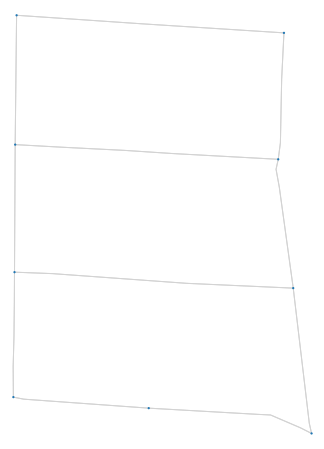

       0      1      2      3      4      5      6      7      8
0    0.0  239.2  337.9  438.7  540.9  115.7  131.9  218.7  318.7
1  239.2    0.0   98.7  199.4  301.7  319.3  107.3  407.6  513.3
2  337.9   98.7    0.0  100.8  203.0  220.6  206.0  308.9  414.6
3  438.7  199.4  100.8    0.0  102.2  321.4  306.8  208.2  313.9
4  540.9  301.7  203.0  102.2    0.0  423.6  409.0  310.4  211.7
5  115.7  319.3  220.6  321.4  423.6    0.0  247.7  102.9  203.0
6  131.9  107.3  206.0  306.8  409.0  247.7    0.0  350.6  450.6
7  218.7  407.6  308.9  208.2  310.4  102.9  350.6    0.0  100.0
8  318.7  513.3  414.6  313.9  211.7  203.0  450.6  100.0    0.0


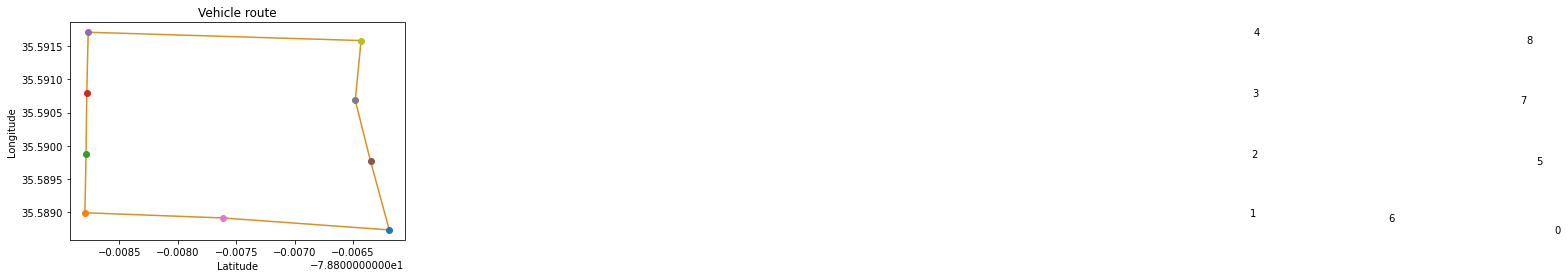

[[(2, 1), (1, 6), (6, 0), (0, 5), (5, 7), (7, 8), (8, 4), (4, 3), (3, 2)]]


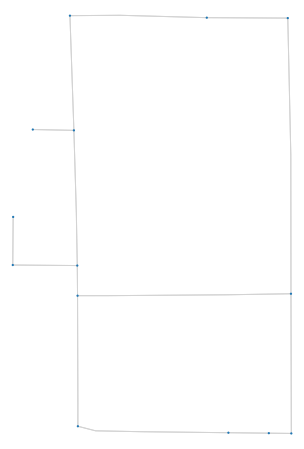

       0      1      2      3      4      5      6      7      8      9   \
0     0.0  135.3  397.7  101.7  187.2  259.8  217.7   82.6  346.4  213.3   
1   135.3    0.0  262.8  237.0  322.6  395.1   88.4  218.0  314.1  348.6   
2   397.7  262.8    0.0  296.0  210.4  137.9  174.4  315.0   51.3  236.5   
3   101.7  237.0  296.0    0.0   85.6  158.1  154.1   19.0  244.7  111.6   
4   187.2  322.6  210.4   85.6    0.0   72.6  239.6  104.6  159.2   26.1   
5   259.8  395.1  137.9  158.1   72.6    0.0  312.2  177.1   86.6   98.6   
6   217.7   88.4  174.4  154.1  239.6  312.2    0.0  135.1  225.7  265.7   
7    82.6  218.0  309.5   19.0  104.6  177.1  135.1    0.0  263.7  130.6   
8   346.4  314.1   51.3  244.7  159.2   86.6  225.7  263.7    0.0  185.2   
9   333.6  469.0  356.9  232.0  146.4  219.0  386.1  251.0  305.6    0.0   
10  142.5  277.8  336.8   40.8  126.4  198.9  194.9   59.8  285.5  152.4   
11  172.9  308.3  367.3   71.3  156.8  229.4  225.4   90.3  316.0  182.9   
12  121.1   

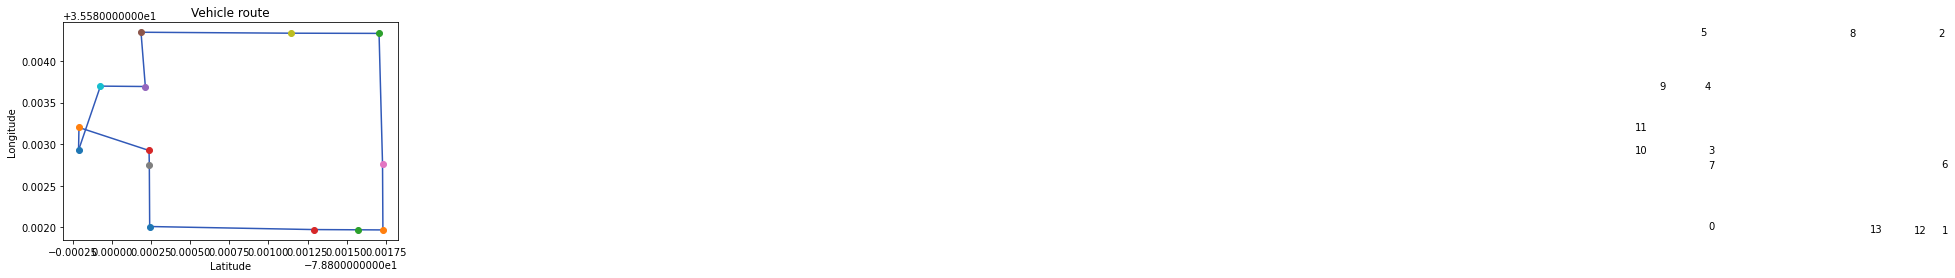

[[(2, 8), (8, 5), (5, 4), (4, 9), (9, 10), (10, 11), (11, 3), (3, 7), (7, 0), (0, 13), (13, 12), (12, 1), (1, 6), (6, 2)]]


In [95]:
for i in range(2):
    
    #Creating a bounding box
    north, south, east, west = bb[i][0],bb[i][1],bb[i][2],bb[i][3]
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
    Nodes = []
    for i in G.nodes:
        Nodes.append(i)

    data = pd.DataFrame(Nodes)
    data.rename(columns = {0:'Nodes'}, inplace = True)

    lat1 = []
    long1 = []
    for i in Nodes:
        lat1.append(G.nodes[i].get('y'))
        long1.append(G.nodes[i].get('x'))
    data['Latitude'] = lat1
    data['Longitude'] = long1
    df1 = data


    df1 = df1.drop(['Nodes'],axis=1)
    df1.rename(columns = {'Latitude':'Left'}, inplace = True)
    df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
    df3 = pd.DataFrame()
    for j in df1.index:
        list1 = []
        for i in df1.index:
            r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
            list1.append(json.loads(r.content)["routes"][0]["distance"])
        df3[j] = list1
    df = df1
    df['coordinate'] = list(zip(df['Right'],df['Left']))
    df['ID'] = df.index

    locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
    distances_df = df3
    distance = distances_df
    distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)
    print(df3)

    ## V: This defines the total number of vehicles that will traverse the path.
    V = 1
    ## prob: This initializes the problem that will run using provided constraints.

    prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
    indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
    eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
    cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
    prob+=cost

    start1 = depot1
    for v in df.ID:
        ## cap: This considers a particular node at a time. 
        cap = 1 if v != start1 else V
        #inward possible route
        prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
        prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
    num=len(df.ID)/V
    for i in df.ID:
        for j in df.ID:
            if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
                prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1


    prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
    feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
    def get_next_loc(initial):
        edges = [e for e in feasible_edges if e[0]==initial]
        for e in edges:
            feasible_edges.remove(e)
        return edges
    ## routes: This stores information regarding paths.    
    routes = get_next_loc(2)
    routes = [ [e] for e in routes ]

    for r in routes:
        while r[-1][1] !=start1:
            r.append(get_next_loc(r[-1][1])[-1])
    ## coloured_loc: This stores information according to individual paths.        
    coloured_loc = [np.random.rand(3) for i in range(len(routes))]
    for r,co in zip(routes,coloured_loc):
        for a,b in r:
            l1,l2 = locations[a], locations[b]
            plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
    for l in locations:
        lo = locations[l]
        plt.plot(lo[0],lo[1],'o')
        plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')


    plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()        

    print(routes)
    ##@ package create_data_model
    # Stores the data for the problem.
    def create_data_model():
        data = {}
        data['distance_matrix'] = distance

        data['num_vehicles'] = 5

        data['num_vehicles'] = 3

        data['depot'] = 7
        return data

    ##@print_solution
    #Prints solution on console.
    def print_solution(data, manager, routing, solution):

        max_route_distance = 0
        for vehicle_id in range(data['num_vehicles']):
            index = routing.Start(vehicle_id)
            plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
            route_distance = 0
            while not routing.IsEnd(index):
                plan_output += ' {} -> '.format(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            plan_output += '{}\n'.format(manager.IndexToNode(index))
           #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
            print(plan_output)
            max_route_distance = max(route_distance, max_route_distance)
        #print('Maximum of the route distances: {}m'.format(max_route_distance))

    ##@main
    #Solve the CVRP problem.
    def main():
        # Instantiate the data problem.
        data = create_data_model()
        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                               data['num_vehicles'], data['depot'])
        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)
        # Create and register a transit callback.
        ##Returns the distance between the two nodes.
        def distance_callback(from_index, to_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return data['distance_matrix'][from_node][to_node]
        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
        # Add Distance constraint.
        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  # no slack
            3000,  # vehicle maximum travel distances
            True,  # start cumul to zero
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        distance_dimension.SetGlobalSpanCostCoefficient(100)
        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)
        # Print solution on console.
        #if solution:
            #print_solution(data, manager, routing, solution)
    if __name__ == '__main__':
        main()


    #Visualization
    df2 = df[['Left', 'Right', 'ID']].copy()
    df2.rename(columns = {'Left':'Latitude'}, inplace = True)
    df2.rename(columns = {'Right':'Longitude'}, inplace = True)
    #Creating a list from routes to reorder the indexes
    a=[]
    for i in range(data.index.stop):
        #print(routes[0][i][0])
        a.append(routes[0][i][0]) 
    order1 = [1,6,0,5,2]
    order2 = [7,8,4,3,2]
    df3 = pd.DataFrame()
    for i in a:
        df3 = df3.append(df2.loc[i])
    df4 = pd.DataFrame()
    for i in order2:
        df4 = df4.append(df2.loc[i])
    df3.reset_index(inplace = True)
    df4.reset_index(inplace = True)

    df3 = df3.append(df3.loc[0])
    df4 = df4.append(df4.loc[0])
    df3.reset_index(inplace = True)
    long2 = [] 
    lat2 = []  
    for i in df3.index:
        long2.append(df3.loc[i]["Longitude"])
        lat2.append(df3.loc[i]["Latitude"])

    df4.reset_index(inplace = True)
    long3 = [] 
    lat3 = []  
    for i in df4.index:
        long3.append(df4.loc[i]["Longitude"])
        lat3.append(df4.loc[i]["Latitude"])


    def plot_path(lat, long, origin_point, destination_point):
        fig = go.Figure(go.Scattermapbox(
            name = "Path",
            mode = "lines",
            lon = long,
            lat = lat,
            marker = {'size': 10},
            line = dict(width = 4.5, color = 'grey')))
        fig.add_trace(go.Scattermapbox(
            name = "Source",
            mode = "markers",
            lon = [origin_point[1]],
            lat = [origin_point[0]],
            marker = {'size': 12, 'color':"red"}))
        fig.add_trace(go.Scattermapbox(
            name = "Destination",
            mode = "markers",
            lon = [destination_point[1]],
            lat = [destination_point[0]],
            marker = {'size': 12, 'color':'green'}))
        lat_center = np.mean(lat)
        long_center = np.mean(long)
        fig.update_layout(mapbox_style="carto-darkmatter",
            mapbox_center_lat = 30, mapbox_center_lon=-80)
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                          mapbox = {
                              'center': {'lat': lat_center, 
                              'lon': long_center},
                              'zoom': 13})
        fig.show()


    origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
    destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

    origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
    destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
    plot_path(lat2, long2, origin_point2, destination_point2)
    #plot_path(lat3, long3, origin_point3, destination_point3)

In [96]:
routes

[[(2, 8),
  (8, 5),
  (5, 4),
  (4, 9),
  (9, 10),
  (10, 11),
  (11, 3),
  (3, 7),
  (7, 0),
  (0, 13),
  (13, 12),
  (12, 1),
  (1, 6),
  (6, 2)]]

In [97]:
bb1

[35.588654, 35.591812, -78.808848, -78.806101]

In [98]:
bb3 = [35.596373,35.598830,-78.784815,-78.782240]

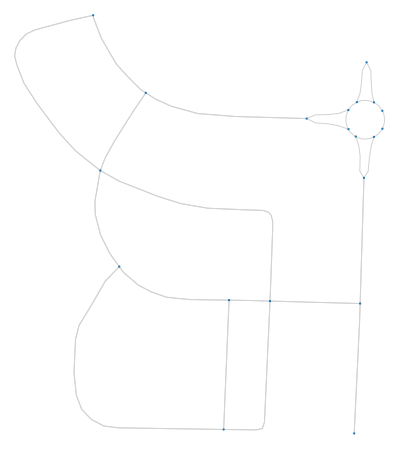

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [99]:
north, south, east, west = bb3[0],bb3[1],bb3[2],bb3[3]
# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

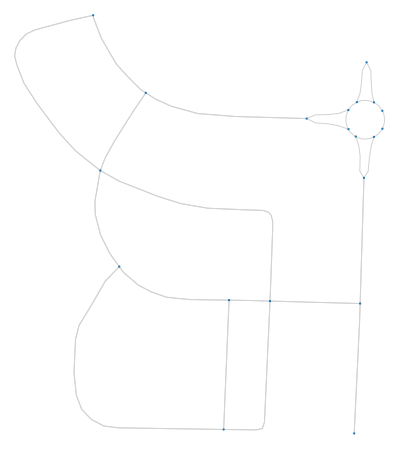

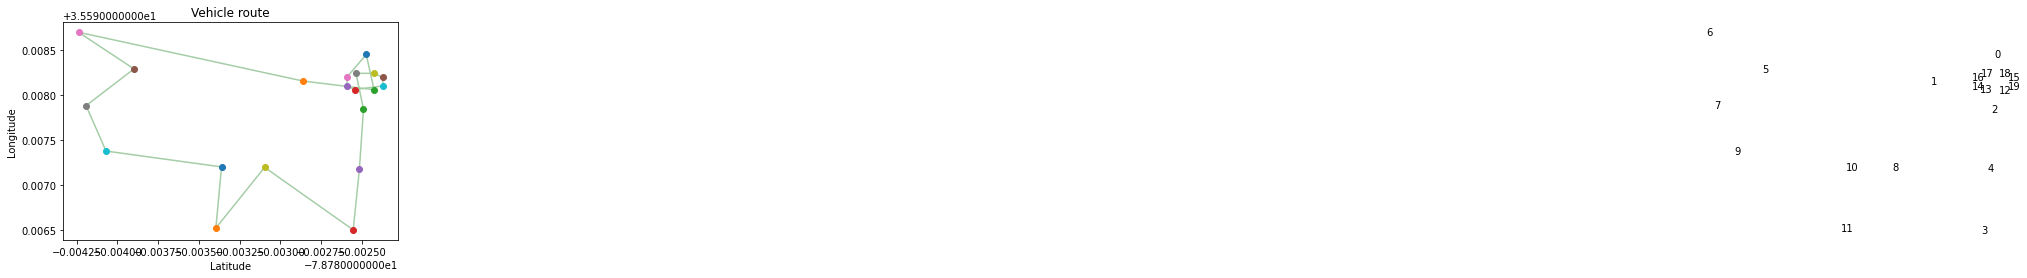

[[(2, 17), (17, 18), (18, 15), (15, 19), (19, 13), (13, 14), (14, 16), (16, 0), (0, 12), (12, 1), (1, 6), (6, 5), (5, 7), (7, 9), (9, 10), (10, 11), (11, 8), (8, 3), (3, 4), (4, 2)]]
2
17
18
15
19
13
14
16
0
12
1
6
5
7
9
10
11
8
3
4


In [103]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

#Creating a bounding box
north, south, east, west = bb3[0],bb3[1],bb3[2],bb3[3]
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(data.index.stop):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
order1 = [1,6,0,5,2]
order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
df4 = pd.DataFrame()
for i in order2:
    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
for i in df4.index:
    long3.append(df4.loc[i]["Longitude"])
    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [104]:
bb3

[35.596373, 35.59883, -78.784815, -78.78224]

In [109]:
bb4 = [35.598926,35.600409,-78.784841,-78.782202]

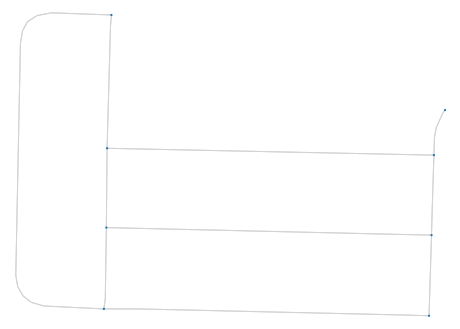

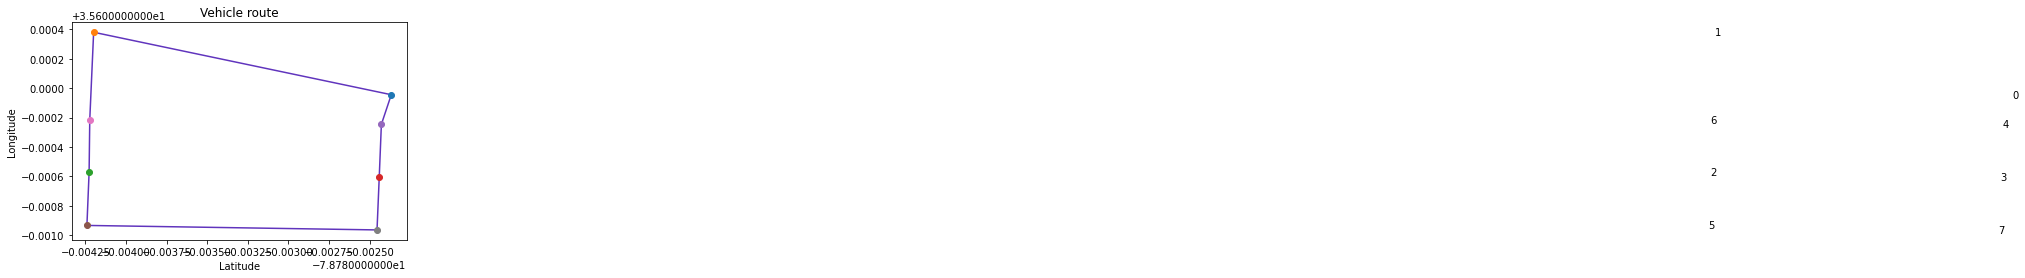

[[(2, 6), (6, 1), (1, 0), (0, 4), (4, 3), (3, 7), (7, 5), (5, 2)]]
2
6
1
0
4
3
7
5


In [114]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

#Creating a bounding box
north, south, east, west = bb4[0],bb4[1],bb4[2],bb4[3]
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


#Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)
    
data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data


df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

#Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


## V: This defines the total number of vehicles that will traverse the path.
V = 1
## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
    ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
    #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
    #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
            prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1
            
            
prob.solve()
## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
##@get_next_loc
# This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])
## coloured_loc: This stores information according to individual paths.        
coloured_loc = [np.random.rand(3) for i in range(len(routes))]
for r,co in zip(routes,coloured_loc):
    for a,b in r:
        l1,l2 = locations[a], locations[b]
        plt.plot([l1[0],l2[0]],[l1[1],l2[1]], color=co)
for l in locations:
    lo = locations[l]
    plt.plot(lo[0],lo[1],'o')
    plt.text(lo[0]+.01,lo[1],l,horizontalalignment='center',verticalalignment='center')
    
    
plt.title('%d '%V + 'Vehicle routes' if V > 1 else 'Vehicle route')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()        

print(routes)
##@ package create_data_model
# Stores the data for the problem.
def create_data_model():
    data = {}
    data['distance_matrix'] = distance

    data['num_vehicles'] = 5

    data['num_vehicles'] = 3

    data['depot'] = 7
    return data

##@print_solution
#Prints solution on console.
def print_solution(data, manager, routing, solution):
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
       #plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print('Maximum of the route distances: {}m'.format(max_route_distance))

##@main
#Solve the CVRP problem.
def main():
    # Instantiate the data problem.
    data = create_data_model()
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    ##Returns the distance between the two nodes.
    def distance_callback(from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distances
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    # Print solution on console.
    #if solution:
        #print_solution(data, manager, routing, solution)
if __name__ == '__main__':
    main()
    

#Visualization
df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
#Creating a list from routes to reorder the indexes
a=[]
for i in range(data.index.stop):
    print(routes[0][i][0])
    a.append(routes[0][i][0]) 
#order1 = [1,6,0,5,2]
#order2 = [7,8,4,3,2]
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])
#df4 = pd.DataFrame()
#for i in order2:
#    df4 = df4.append(df2.loc[i])
df3.reset_index(inplace = True)
#df4.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
#df4 = df4.append(df4.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])

#df4.reset_index(inplace = True)
long3 = [] 
lat3 = []  
#for i in df4.index:
#    long3.append(df4.loc[i]["Longitude"])
#    lat3.append(df4.loc[i]["Latitude"])


def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()
    
    
origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])

#origin_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"]) 
#destination_point3 = (df4.loc[0]["Latitude"], df4.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)
#plot_path(lat3, long3, origin_point3, destination_point3)


In [115]:
routes

[[(2, 6), (6, 1), (1, 0), (0, 4), (4, 3), (3, 7), (7, 5), (5, 2)]]

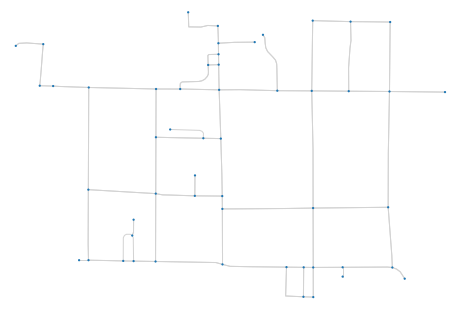

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [121]:
north, south, east, west = 35.581304,35.585510,-78.795250,-78.803511
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)